In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import re
from struct import *

### Define read_PFM function

In [2]:
def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img

#### 2.1.1--- Estimate depth using the stereo image pair. Show the results of varying the following parameters: blockSize  [5; 9; 15], numDisparities [16; 32; 48]. You will have a total of 9 depth-maps, each corresponding to one combination of blocksize and numDisparities. (5 points)

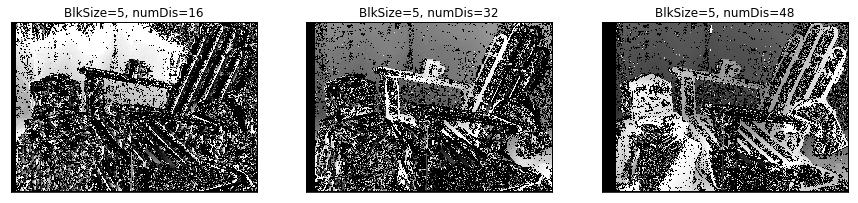

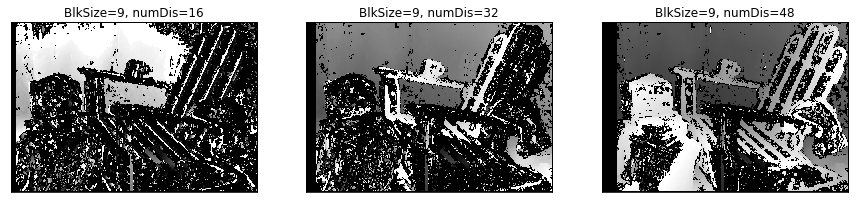

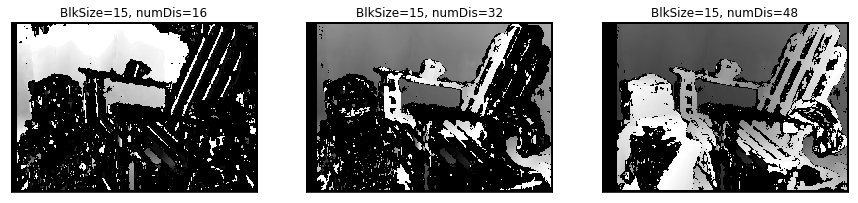

In [3]:
# load left and right images
dispL_path = './Adirondack-perfect/im0.png'
dispR_path = './Adirondack-perfect/im1.png'

# load left and right images
imgL = cv2.imread(dispL_path);
imgR = cv2.imread(dispR_path);

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)


# create 2 arrays to store blockSize and numDisparities
blkSize = np.array([5,9,15])
numDisparity = np.array([16,32,48])
depth_maps = []

# compute disparity map
for i in range (blkSize.shape[0]):
    for j in range(numDisparity.shape[0]):
        stereo = cv2.StereoBM_create(numDisparities=numDisparity[j], blockSize=blkSize[i])
        disparity = stereo.compute(imgL_gray, imgR_gray) #double check if it's in range of 0-255
        depth_maps.append(disparity)
        

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(depth_maps[0], cmap="gray")
plt.title("BlkSize=5, numDis=16"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(depth_maps[1], cmap="gray")
plt.title("BlkSize=5, numDis=32"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(depth_maps[2], cmap="gray")
plt.title("BlkSize=5, numDis=48"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(depth_maps[3], cmap="gray")
plt.title("BlkSize=9, numDis=16"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(depth_maps[4], cmap="gray")
plt.title("BlkSize=9, numDis=32"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(depth_maps[5], cmap="gray")
plt.title("BlkSize=9, numDis=48"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(depth_maps[6], cmap="gray")
plt.title("BlkSize=15, numDis=16"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(depth_maps[7], cmap="gray")
plt.title("BlkSize=15, numDis=32"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(depth_maps[8],cmap = "gray")
plt.title("BlkSize=15, numDis=48"), plt.xticks([]), plt.yticks([])
plt.show()



#### 2.1.2---For each depth-map, compute the pixel-wise squared difference error with respect to the ground-truth. (2 points)

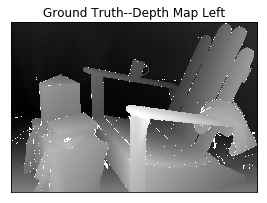

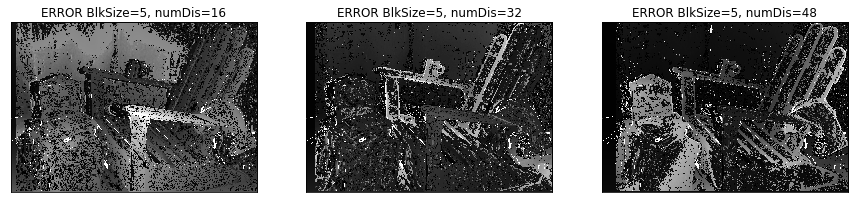

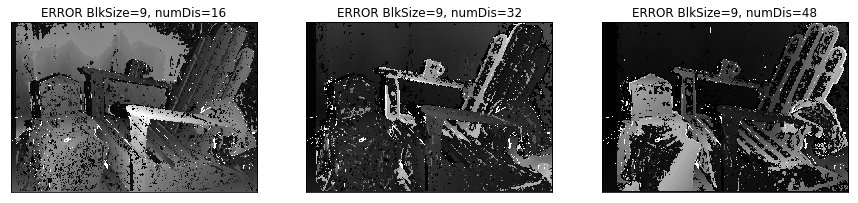

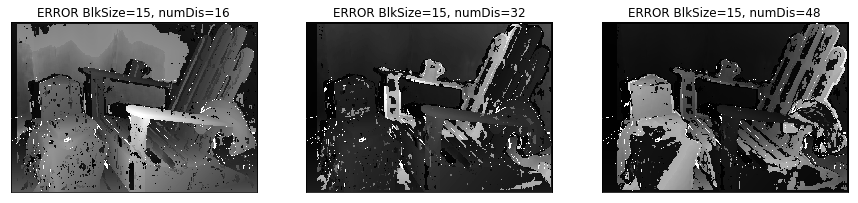

In [4]:
#  read ground truth image (left depth map given)
groundTruth_path = './Adirondack-perfect/disp0.pfm'
ground_truth = read_pfm(groundTruth_path)

ground_truth = cv2.resize(ground_truth, None, fx=0.3, fy=0.3)

error_img = np.zeros(shape=(ground_truth.shape[0],ground_truth.shape[1]))
error_images = []

# compute the pixel-wise SD error w/r to ground truth
for idx in range(len(depth_maps)):
    for row in range(ground_truth.shape[0]): # 596
        for col in range(ground_truth.shape[1]): # 864
#             compute the squared-difference error
            diff = (depth_maps[idx])[row,col] - ground_truth[row,col]
            error = np.power(diff,2)
            error_img[row,col] = error
            
#   add error_image from each iteration to the list
    error_images.append(error_img)
    error_img = np.zeros(shape=(ground_truth.shape[0],ground_truth.shape[1]))

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(ground_truth, cmap="gray")
plt.title("Ground Truth--Depth Map Left"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(error_images[0], cmap="gray")
plt.title("ERROR BlkSize=5, numDis=16"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(error_images[1], cmap="gray")
plt.title("ERROR BlkSize=5, numDis=32"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(error_images[2], cmap="gray")
plt.title("ERROR BlkSize=5, numDis=48"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(error_images[3], cmap="gray")
plt.title("ERROR BlkSize=9, numDis=16"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(error_images[4], cmap="gray")
plt.title("ERROR BlkSize=9, numDis=32"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(error_images[5], cmap="gray")
plt.title("ERROR BlkSize=9, numDis=48"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(error_images[6], cmap="gray")
plt.title("ERROR BlkSize=15, numDis=16"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(error_images[7], cmap="gray")
plt.title("ERROR BlkSize=15, numDis=32"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(error_images[8], cmap="gray")
plt.title("ERROR BlkSize=15, numDis=48"), plt.xticks([]), plt.yticks([])
plt.show()

#### 2.1.3---Comment on the error-maps for each combination of parameters. Specifically, mention the effects of varying the parameters on the error in the region of high/low texture, edge, large/small depths. (6 points)

numDisparities is the disparity search range, which indicates the levels of depth that the image can have. If numDisparities is larger, it means that the depth_map of the image will have more shades, hencing displaying more levels of depth. If numDisparities increases, we would obtain a more accurate disparity map since more intervals of distance would be shown and there will be a more obvious contrast between the large/small depths and high/low texture. 

blockSize is the kernel size(search window size) we use for computing disparity map. Larger block would generate smoother surface on both regions of high/low texture, but the resulting depth map is less accurate. Smaller block would generate a more detailed depth map, however there might be a higher possibility of finding the incorrect corresponding result. If the blockSize is smaller, the edges would be more distinct. 

Theoretically speaking, a medium blockSize and a relatively large numDisparities is more likely to output the most desirable disparity map. 

